In [28]:
import pandas as pd
from itertools import combinations
from collections import defaultdict
import pandas as pd
import time
import matplotlib.pyplot as plt

def load_sample_dataset():
    """
    Load a sample dataset for demonstration purposes.
    
    Each list within the main list represents a transaction with several items.
    """
    transactions = [
        ['Bread', 'Milk'],
        ['Bread', 'Diapers', 'Beer', 'Eggs'],
        ['Milk', 'Diapers', 'Beer', 'Cola'],
        ['Bread', 'Milk', 'Diapers', 'Beer'],
        ['Bread', 'Milk', 'Diapers', 'Cola']
    ]
    #Import dataset from data folder where each row is a transaction
    dataset = pd.read_csv('./data/transactions.dat', header=None)

   # dataset = dataset.values.tolist()
    return transactions

def apriori(transactions, min_support):
    """
    Implements the A-Priori algorithm for finding frequent itemsets.

    :param transactions: List of transactions (each transaction is a list of items)
    :param min_support: Minimum support threshold
    :return: Dictionary of frequent itemsets with their support
    """
    timings = []
    start_time = time.time()
    # Function to get itemsets of a given size
    def get_itemsets(transactions, size):
        itemsets = set()
        for transaction in transactions:
            # Generate all combinations of items in the transaction of the given size
            for itemset in combinations(transaction, size): #The question is... Can we use this:D? https://docs.python.org/3/library/itertools.html#itertools.combinations
                itemsets.add(itemset)
        return itemsets

    def calculate_support(transactions, itemsets):
        support = defaultdict(int) # {} was not working for me, so I used defaultdict
        # Convert transactions to sets once at the beginning because it will be used several times and is more efficient
        set_transactions = [set(transaction) for transaction in transactions]

        for itemset in itemsets:
            set_itemset = set(itemset)
            itemset_len = len(set_itemset)
            for transaction in set_transactions:
                # Early exit if the transaction is smaller than the itemset (improves performance) because itemset ('Diapers', 'Beer', 'Cola') can't be subset of
                # this transaction {'Milk', 'Bread'}  
                if len(transaction) < itemset_len:
                   # print("Transaction is smaller than itemset", transaction, itemset)
                    continue
                if set_itemset.issubset(transaction):
                    support[itemset] += 1
        return support


    #Main part of the algorithm
    all_frequent_itemsets = dict()
    k = 2  # Starting with individual items, later increasing he k for pairs, triples, etc.
    frequent_itemsets = get_itemsets(transactions, k)
    
    print("Before:", frequent_itemsets)
    # Loop through each level (single items, pairs, triples, etc.)
    while frequent_itemsets:
        # Calculate support for each itemset


        itemset_support = calculate_support(transactions, frequent_itemsets)
        # Select itemsets with support greater or equal to min_support
        frequent_itemsets = dict(filter(lambda item: item[1] >= min_support, itemset_support.items())) #Filter is more efficient than simple iteration
        print("k-frequent sets:",k, frequent_itemsets)
        # Add the frequent itemsets to the final dictionary
        all_frequent_itemsets.update({itemset: itemset_support[itemset] for itemset in frequent_itemsets})
        # Increase the itemset size for the next loop iteration
        
        end_time = time.time()  # End timing
        timings.append((k, end_time - start_time))  # Record the time taken for this iteration

        k += 1
        frequent_itemsets = get_itemsets(transactions, k)

    return all_frequent_itemsets, timings

sample_transactions = load_sample_dataset()
min_support = 2  #  threshold
frequent_itemsets, timings = apriori(sample_transactions, min_support)



Before: {('Diapers', 'Eggs'), ('Milk', 'Diapers'), ('Diapers', 'Cola'), ('Bread', 'Diapers'), ('Bread', 'Eggs'), ('Bread', 'Cola'), ('Bread', 'Beer'), ('Milk', 'Cola'), ('Beer', 'Cola'), ('Milk', 'Beer'), ('Beer', 'Eggs'), ('Bread', 'Milk'), ('Diapers', 'Beer')}
k-frequent sets: 2 {('Milk', 'Diapers'): 3, ('Diapers', 'Cola'): 2, ('Bread', 'Diapers'): 3, ('Bread', 'Beer'): 2, ('Milk', 'Cola'): 2, ('Milk', 'Beer'): 2, ('Bread', 'Milk'): 3, ('Diapers', 'Beer'): 3}
k-frequent sets: 3 {('Milk', 'Diapers', 'Cola'): 2, ('Bread', 'Milk', 'Diapers'): 2, ('Milk', 'Diapers', 'Beer'): 2, ('Bread', 'Diapers', 'Beer'): 2}
k-frequent sets: 4 {}


In [29]:
# Print the results
print(frequent_itemsets)

{('Milk', 'Diapers'): 3, ('Diapers', 'Cola'): 2, ('Bread', 'Diapers'): 3, ('Bread', 'Beer'): 2, ('Milk', 'Cola'): 2, ('Milk', 'Beer'): 2, ('Bread', 'Milk'): 3, ('Diapers', 'Beer'): 3, ('Milk', 'Diapers', 'Cola'): 2, ('Bread', 'Milk', 'Diapers'): 2, ('Milk', 'Diapers', 'Beer'): 2, ('Bread', 'Diapers', 'Beer'): 2}


 k  Time (seconds)
 2             0.0
 3             0.0
 4             0.0


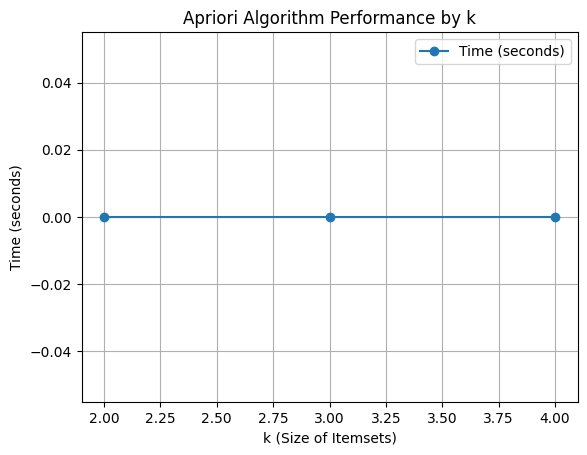

In [30]:
timings_df = pd.DataFrame(timings, columns=['k', 'Time (seconds)'])


print(timings_df.to_string(index=False))
# Plotting
timings_df.plot(x='k', y='Time (seconds)', kind='line', marker='o', title='Apriori Algorithm Performance by k')
plt.xlabel('k (Size of Itemsets)')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()